In [1]:
import pandas as pd
import numpy as np
from stellargraph import StellarGraph

base_path = "/home/colombelli/Documents/datasets/acgt/kidney/stellargraph/"
edges_file = base_path+"patients_edges.csv"
features_file = base_path+"patients_features.csv"
classes_file = base_path+"patients_classes.csv"

In [2]:
# Imports required for following the tutorial: 
# https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

In [3]:
# Loading data and building the StellarGraph object

df_patients = pd.read_csv(edges_file)
df_features = pd.read_csv(features_file, index_col=0)
df_classes = pd.read_csv(classes_file, index_col=0).sample(frac=1)

In [4]:
G = StellarGraph(edges=df_patients, nodes=df_features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 429, Edges: 3618

 Node types:
  default: [429]
    Features: float32 vector, length 500
    Edge types: default-default->default

 Edge types:
    default-default->default: [3618]
        Weights: range=[0.700006, 1], mean=0.817409, std=0.100909
        Features: none


In [8]:
# Splitting data into train/validation/test

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

series_classes = df_classes['class']
#series_classes = series_classes.sample(frac=1)

train_subjects, test_subjects = model_selection.train_test_split(
    series_classes, test_size=1-train_ratio, stratify=series_classes)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, test_size=test_ratio/(test_ratio + validation_ratio), stratify=test_subjects)

print("Len train: ", len(train_subjects))
print("Len validation: ", len(val_subjects))
print("Len test: ", len(test_subjects))
print("\nLen everything: ", len(val_subjects)+len(test_subjects)+len(train_subjects))

Len train:  300
Len validation:  64
Len test:  65

Len everything:  429


In [6]:
from collections import Counter
counter = Counter(train_subjects)
counter

Counter({'stage1': 143,
         'stage3': 49,
         'stage4': 34,
         'control': 50,
         'stage2': 24})

In [7]:
from collections import Counter
counter = Counter(val_subjects)
counter

Counter({'stage1': 30, 'stage3': 10, 'stage2': 5, 'control': 11, 'stage4': 8})

In [8]:
from collections import Counter
counter = Counter(test_subjects)
counter

Counter({'stage1': 31, 'control': 11, 'stage4': 7, 'stage3': 11, 'stage2': 5})

In [9]:
"""
target_encoding.inverse_transform(np.array([[1,0,0,0,0], 
                                            [0,1,0,0,0],
                                            [0,0,1,0,0],
                                            [0,0,0,1,0],
                                            [0,0,0,0,1]]))
"""

'\ntarget_encoding.inverse_transform(np.array([[1,0,0,0,0], \n                                            [0,1,0,0,0],\n                                            [0,0,1,0,0],\n                                            [0,0,0,1,0],\n                                            [0,0,0,0,1]]))\n'

In [10]:
# weights logic taken from: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
num_samples = 0
for cls in counter:
    num_samples += counter[cls]
num_classes = len(counter)

w_control = num_samples / (num_classes * counter['control'])
w_s1 = num_samples / (num_classes * counter['stage1'])
w_s2 = num_samples / (num_classes * counter['stage2'])
w_s3 = num_samples / (num_classes * counter['stage3'])
w_s4 = num_samples / (num_classes * counter['stage4'])

weights = np.array([w_control, w_s1, w_s2, w_s3, w_s4])
weights

array([1.18181818, 0.41935484, 2.6       , 1.18181818, 1.85714286])

## The cell below is used to downsample the training data. Skip it if this is not the goal

In [11]:
"""
train_subjects_downsample = train_subjects.loc[train_subjects == 'stage1'][0:50].append(
            train_subjects.loc[train_subjects == 'stage2'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage3'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage4'][0:50]).append(
            train_subjects.loc[train_subjects == 'control'][0:50])

train_subjects=train_subjects_downsample
Counter(train_subjects_downsample)
"""

"\ntrain_subjects_downsample = train_subjects.loc[train_subjects == 'stage1'][0:50].append(\n            train_subjects.loc[train_subjects == 'stage2'][0:50]).append(\n            train_subjects.loc[train_subjects == 'stage3'][0:50]).append(\n            train_subjects.loc[train_subjects == 'stage4'][0:50]).append(\n            train_subjects.loc[train_subjects == 'control'][0:50])\n\ntrain_subjects=train_subjects_downsample\nCounter(train_subjects_downsample)\n"

In [10]:
# Converting to one-hot encoding

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [13]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [14]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

nb_classes = 5
input_dim = df_features.loc[train_subjects.index].values.shape[1]

model = Sequential()
model.add(Dense(64, input_dim=input_dim))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(64))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), 
              metrics=["acc", metrics.AUC(curve="ROC"), metrics.AUC(curve="PR")])



X_train = df_features.loc[train_subjects.index].values
y_train = train_targets

X_val = df_features.loc[val_subjects.index].values
y_val = val_targets

print("Training...")
history = model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=8, verbose=2)

Training...
Epoch 1/250
38/38 - 3s - loss: 6.3892 - acc: 0.2433 - auc: 0.5585 - auc_1: 0.2369 - val_loss: 2.3324 - val_acc: 0.5938 - val_auc: 0.7288 - val_auc_1: 0.4295
Epoch 2/250
38/38 - 0s - loss: 2.5838 - acc: 0.3933 - auc: 0.7137 - auc_1: 0.3959 - val_loss: 1.9212 - val_acc: 0.5938 - val_auc: 0.7743 - val_auc_1: 0.5383
Epoch 3/250
38/38 - 0s - loss: 2.1994 - acc: 0.4333 - auc: 0.7367 - auc_1: 0.4313 - val_loss: 1.7155 - val_acc: 0.6250 - val_auc: 0.8211 - val_auc_1: 0.5895
Epoch 4/250
38/38 - 0s - loss: 1.6078 - acc: 0.5467 - auc: 0.8185 - auc_1: 0.5783 - val_loss: 1.4310 - val_acc: 0.5625 - val_auc: 0.8316 - val_auc_1: 0.6461
Epoch 5/250
38/38 - 0s - loss: 1.4467 - acc: 0.5500 - auc: 0.8189 - auc_1: 0.5893 - val_loss: 1.2809 - val_acc: 0.6094 - val_auc: 0.8564 - val_auc_1: 0.6714
Epoch 6/250
38/38 - 0s - loss: 1.3943 - acc: 0.6000 - auc: 0.8304 - auc_1: 0.6094 - val_loss: 1.2035 - val_acc: 0.5938 - val_auc: 0.8625 - val_auc_1: 0.6836
Epoch 7/250
38/38 - 0s - loss: 1.2117 - acc: 0

Epoch 53/250
38/38 - 0s - loss: 0.4325 - acc: 0.8500 - auc: 0.9766 - auc_1: 0.9244 - val_loss: 0.9302 - val_acc: 0.6719 - val_auc: 0.9132 - val_auc_1: 0.7843
Epoch 54/250
38/38 - 0s - loss: 0.3818 - acc: 0.8567 - auc: 0.9829 - auc_1: 0.9433 - val_loss: 0.9223 - val_acc: 0.6875 - val_auc: 0.9136 - val_auc_1: 0.7819
Epoch 55/250
38/38 - 0s - loss: 0.3222 - acc: 0.8733 - auc: 0.9897 - auc_1: 0.9648 - val_loss: 0.9805 - val_acc: 0.6719 - val_auc: 0.9109 - val_auc_1: 0.7806
Epoch 56/250
38/38 - 0s - loss: 0.3360 - acc: 0.8800 - auc: 0.9883 - auc_1: 0.9598 - val_loss: 1.0138 - val_acc: 0.6719 - val_auc: 0.9106 - val_auc_1: 0.7768
Epoch 57/250
38/38 - 0s - loss: 0.3523 - acc: 0.8800 - auc: 0.9858 - auc_1: 0.9543 - val_loss: 1.0609 - val_acc: 0.6719 - val_auc: 0.9085 - val_auc_1: 0.7723
Epoch 58/250
38/38 - 0s - loss: 0.3433 - acc: 0.8800 - auc: 0.9857 - auc_1: 0.9499 - val_loss: 1.0042 - val_acc: 0.6719 - val_auc: 0.9098 - val_auc_1: 0.7773
Epoch 59/250
38/38 - 0s - loss: 0.3094 - acc: 0.8933

Epoch 105/250
38/38 - 0s - loss: 0.0986 - acc: 0.9733 - auc: 0.9990 - auc_1: 0.9963 - val_loss: 1.2609 - val_acc: 0.6719 - val_auc: 0.8966 - val_auc_1: 0.7544
Epoch 106/250
38/38 - 0s - loss: 0.1265 - acc: 0.9600 - auc: 0.9984 - auc_1: 0.9944 - val_loss: 1.3114 - val_acc: 0.6406 - val_auc: 0.8935 - val_auc_1: 0.7463
Epoch 107/250
38/38 - 0s - loss: 0.1098 - acc: 0.9567 - auc: 0.9989 - auc_1: 0.9958 - val_loss: 1.2816 - val_acc: 0.6406 - val_auc: 0.8906 - val_auc_1: 0.7386
Epoch 108/250
38/38 - 0s - loss: 0.0775 - acc: 0.9867 - auc: 0.9998 - auc_1: 0.9991 - val_loss: 1.2826 - val_acc: 0.6250 - val_auc: 0.8930 - val_auc_1: 0.7371
Epoch 109/250
38/38 - 0s - loss: 0.0868 - acc: 0.9767 - auc: 0.9995 - auc_1: 0.9982 - val_loss: 1.2086 - val_acc: 0.6094 - val_auc: 0.9025 - val_auc_1: 0.7557
Epoch 110/250
38/38 - 0s - loss: 0.0971 - acc: 0.9767 - auc: 0.9995 - auc_1: 0.9981 - val_loss: 1.3790 - val_acc: 0.6562 - val_auc: 0.8972 - val_auc_1: 0.7481
Epoch 111/250
38/38 - 0s - loss: 0.0941 - acc:

Epoch 157/250
38/38 - 0s - loss: 0.0537 - acc: 0.9800 - auc: 0.9997 - auc_1: 0.9990 - val_loss: 1.4501 - val_acc: 0.6406 - val_auc: 0.8896 - val_auc_1: 0.7203
Epoch 158/250
38/38 - 0s - loss: 0.0257 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 1.5442 - val_acc: 0.6406 - val_auc: 0.8965 - val_auc_1: 0.7229
Epoch 159/250
38/38 - 0s - loss: 0.0249 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 1.5541 - val_acc: 0.6562 - val_auc: 0.8835 - val_auc_1: 0.7073
Epoch 160/250
38/38 - 0s - loss: 0.0320 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 1.5390 - val_acc: 0.6406 - val_auc: 0.8803 - val_auc_1: 0.7111
Epoch 161/250
38/38 - 0s - loss: 0.0380 - acc: 0.9933 - auc: 0.9999 - auc_1: 0.9997 - val_loss: 1.6122 - val_acc: 0.6562 - val_auc: 0.8830 - val_auc_1: 0.6983
Epoch 162/250
38/38 - 0s - loss: 0.0511 - acc: 0.9833 - auc: 0.9997 - auc_1: 0.9989 - val_loss: 1.6860 - val_acc: 0.6719 - val_auc: 0.8780 - val_auc_1: 0.7062
Epoch 163/250
38/38 - 0s - loss: 0.0283 - acc:

Epoch 209/250
38/38 - 0s - loss: 0.0150 - acc: 0.9933 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 1.8578 - val_acc: 0.6719 - val_auc: 0.8808 - val_auc_1: 0.7076
Epoch 210/250
38/38 - 0s - loss: 0.0148 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 1.8084 - val_acc: 0.6719 - val_auc: 0.8815 - val_auc_1: 0.7112
Epoch 211/250
38/38 - 0s - loss: 0.0290 - acc: 0.9900 - auc: 0.9999 - auc_1: 0.9997 - val_loss: 1.8177 - val_acc: 0.6719 - val_auc: 0.8801 - val_auc_1: 0.7121
Epoch 212/250
38/38 - 0s - loss: 0.0219 - acc: 0.9900 - auc: 1.0000 - auc_1: 0.9999 - val_loss: 1.6580 - val_acc: 0.6250 - val_auc: 0.8774 - val_auc_1: 0.7257
Epoch 213/250
38/38 - 0s - loss: 0.0239 - acc: 0.9933 - auc: 1.0000 - auc_1: 0.9998 - val_loss: 1.8687 - val_acc: 0.6719 - val_auc: 0.8834 - val_auc_1: 0.7137
Epoch 214/250
38/38 - 0s - loss: 0.0244 - acc: 0.9933 - auc: 1.0000 - auc_1: 0.9998 - val_loss: 1.7132 - val_acc: 0.6250 - val_auc: 0.8834 - val_auc_1: 0.7003
Epoch 215/250
38/38 - 0s - loss: 0.0308 - acc:

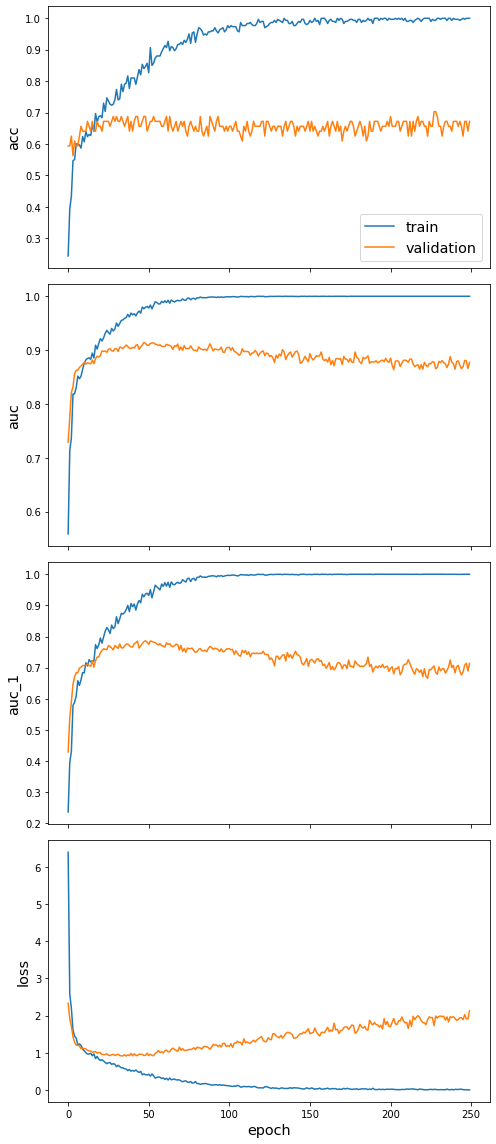

In [15]:
sg.utils.plot_history(history)

In [16]:
X_test = df_features.loc[test_subjects.index].values
y_test = test_targets

test_metrics = model.evaluate(X_test, y_test)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

3/3 [==============================] - 1s 3ms/step - loss: 2.3840 - acc: 0.6308 - auc: 0.8288 - auc_1: 0.6303

Test Set Metrics:
	loss: 2.3840
	acc: 0.6308
	auc: 0.8288
	auc_1: 0.6303


In [17]:
"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from __future__ import print_function
from tensorflow import cast, int64, float32
from keras import backend as K


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        y_true = cast(y_true, dtype=float32)
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

In [18]:
gat = GAT(
    layer_sizes=[100, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.1,
    attn_dropout=0.1,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()

In [19]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.0001),
    loss=losses.categorical_crossentropy,
    #loss=weighted_categorical_crossentropy(np.array([1,1,1,1,1])),#weights/(max(weights)+1)),#weights),#weights/(max(weights)+1)),
    metrics=["acc", metrics.AUC(curve="ROC"), metrics.AUC(curve="PR")],
)

val_gen = generator.flow(val_subjects.index, val_targets)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
    
es_callback = EarlyStopping(
    monitor="val_acc", patience=500#200
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [21]:
history = model.fit(
    train_gen,
    epochs=250,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/250
1/1 - 5s - loss: 9.0289 - acc: 0.1200 - auc_2: 0.3919 - auc_3: 0.1606 - val_loss: 5.4991 - val_acc: 0.0781 - val_auc_2: 0.4412 - val_auc_3: 0.1659
Epoch 2/250
1/1 - 0s - loss: 6.9178 - acc: 0.1200 - auc_2: 0.4399 - auc_3: 0.1736 - val_loss: 4.6297 - val_acc: 0.3906 - val_auc_2: 0.6229 - val_auc_3: 0.2813
Epoch 3/250
1/1 - 0s - loss: 4.8246 - acc: 0.3200 - auc_2: 0.6032 - auc_3: 0.2850 - val_loss: 5.2884 - val_acc: 0.4688 - val_auc_2: 0.6722 - val_auc_3: 0.3413
Epoch 4/250
1/1 - 0s - loss: 5.9384 - acc: 0.3100 - auc_2: 0.6021 - auc_3: 0.2629 - val_loss: 6.1289 - val_acc: 0.4688 - val_auc_2: 0.6728 - val_auc_3: 0.3775
Epoch 5/250
1/1 - 0s - loss: 5.7441 - acc: 0.4100 - auc_2: 0.6573 - auc_3: 0.3239 - val_loss: 6.4695 - val_acc: 0.4688 - val_auc_2: 0.6766 - val_auc_3: 0.3796
Epoch 6/250
1/1 - 0s - loss: 5.9584 - acc: 0.3967 - auc_2: 0.6414 - auc_3: 0.3224 - val_loss: 6.4364 - val_acc: 0.4688 - val_auc_2: 0.6738 - val_auc_3: 0.3710
Epoch 7/250
1/1 - 0s - loss: 4.2949 - acc: 0.4

Epoch 53/250
1/1 - 0s - loss: 2.4109 - acc: 0.5600 - auc_2: 0.7816 - auc_3: 0.5511 - val_loss: 2.0606 - val_acc: 0.6406 - val_auc_2: 0.8467 - val_auc_3: 0.6746
Epoch 54/250
1/1 - 0s - loss: 2.2896 - acc: 0.5733 - auc_2: 0.8016 - auc_3: 0.5413 - val_loss: 2.0462 - val_acc: 0.6406 - val_auc_2: 0.8459 - val_auc_3: 0.6799
Epoch 55/250
1/1 - 0s - loss: 2.2771 - acc: 0.6267 - auc_2: 0.8183 - auc_3: 0.5951 - val_loss: 1.8675 - val_acc: 0.6562 - val_auc_2: 0.8573 - val_auc_3: 0.7049
Epoch 56/250
1/1 - 0s - loss: 2.2675 - acc: 0.6167 - auc_2: 0.8210 - auc_3: 0.6103 - val_loss: 1.6106 - val_acc: 0.6719 - val_auc_2: 0.8674 - val_auc_3: 0.7209
Epoch 57/250
1/1 - 0s - loss: 2.1273 - acc: 0.5167 - auc_2: 0.7991 - auc_3: 0.5501 - val_loss: 1.4125 - val_acc: 0.7031 - val_auc_2: 0.8763 - val_auc_3: 0.7372
Epoch 58/250
1/1 - 0s - loss: 2.1901 - acc: 0.5433 - auc_2: 0.8029 - auc_3: 0.5659 - val_loss: 1.2625 - val_acc: 0.6562 - val_auc_2: 0.8859 - val_auc_3: 0.7531
Epoch 59/250
1/1 - 0s - loss: 2.0850 - a

Epoch 105/250
1/1 - 0s - loss: 2.1670 - acc: 0.5800 - auc_2: 0.8167 - auc_3: 0.5967 - val_loss: 1.1516 - val_acc: 0.6875 - val_auc_2: 0.9023 - val_auc_3: 0.7802
Epoch 106/250
1/1 - 0s - loss: 1.6809 - acc: 0.5967 - auc_2: 0.8391 - auc_3: 0.6284 - val_loss: 1.0882 - val_acc: 0.6719 - val_auc_2: 0.9052 - val_auc_3: 0.7765
Epoch 107/250
1/1 - 0s - loss: 2.0260 - acc: 0.5533 - auc_2: 0.8071 - auc_3: 0.5644 - val_loss: 1.0598 - val_acc: 0.6562 - val_auc_2: 0.9034 - val_auc_3: 0.7736
Epoch 108/250
1/1 - 0s - loss: 2.0531 - acc: 0.5167 - auc_2: 0.8043 - auc_3: 0.5823 - val_loss: 1.0634 - val_acc: 0.6562 - val_auc_2: 0.9034 - val_auc_3: 0.7716
Epoch 109/250
1/1 - 0s - loss: 1.6622 - acc: 0.6167 - auc_2: 0.8455 - auc_3: 0.6688 - val_loss: 1.0603 - val_acc: 0.6406 - val_auc_2: 0.9032 - val_auc_3: 0.7708
Epoch 110/250
1/1 - 0s - loss: 2.0914 - acc: 0.4767 - auc_2: 0.7860 - auc_3: 0.4887 - val_loss: 1.0543 - val_acc: 0.6250 - val_auc_2: 0.9037 - val_auc_3: 0.7697
Epoch 111/250
1/1 - 0s - loss: 2.0

Epoch 156/250
1/1 - 0s - loss: 1.5372 - acc: 0.6067 - auc_2: 0.8564 - auc_3: 0.6654 - val_loss: 1.0443 - val_acc: 0.7188 - val_auc_2: 0.9082 - val_auc_3: 0.7875
Epoch 157/250
1/1 - 0s - loss: 1.7093 - acc: 0.6333 - auc_2: 0.8548 - auc_3: 0.6751 - val_loss: 0.9910 - val_acc: 0.6875 - val_auc_2: 0.9119 - val_auc_3: 0.7826
Epoch 158/250
1/1 - 0s - loss: 1.6108 - acc: 0.5567 - auc_2: 0.8372 - auc_3: 0.6222 - val_loss: 0.9810 - val_acc: 0.6719 - val_auc_2: 0.9123 - val_auc_3: 0.7837
Epoch 159/250
1/1 - 0s - loss: 1.4648 - acc: 0.6000 - auc_2: 0.8597 - auc_3: 0.6598 - val_loss: 1.0108 - val_acc: 0.6719 - val_auc_2: 0.9122 - val_auc_3: 0.7815
Epoch 160/250
1/1 - 0s - loss: 1.4795 - acc: 0.6533 - auc_2: 0.8585 - auc_3: 0.6925 - val_loss: 1.0372 - val_acc: 0.6562 - val_auc_2: 0.9104 - val_auc_3: 0.7744
Epoch 161/250
1/1 - 0s - loss: 1.7421 - acc: 0.5600 - auc_2: 0.8319 - auc_3: 0.6218 - val_loss: 1.0799 - val_acc: 0.6562 - val_auc_2: 0.9060 - val_auc_3: 0.7705
Epoch 162/250
1/1 - 0s - loss: 1.5

Epoch 207/250
1/1 - 0s - loss: 1.3497 - acc: 0.6200 - auc_2: 0.8735 - auc_3: 0.6927 - val_loss: 1.1345 - val_acc: 0.6875 - val_auc_2: 0.8985 - val_auc_3: 0.7538
Epoch 208/250
1/1 - 0s - loss: 1.3954 - acc: 0.6100 - auc_2: 0.8621 - auc_3: 0.6707 - val_loss: 1.1357 - val_acc: 0.6875 - val_auc_2: 0.9046 - val_auc_3: 0.7576
Epoch 209/250
1/1 - 0s - loss: 1.7395 - acc: 0.5567 - auc_2: 0.8273 - auc_3: 0.5872 - val_loss: 1.1389 - val_acc: 0.6875 - val_auc_2: 0.8945 - val_auc_3: 0.7538
Epoch 210/250
1/1 - 0s - loss: 1.4693 - acc: 0.6167 - auc_2: 0.8609 - auc_3: 0.6735 - val_loss: 1.1537 - val_acc: 0.6875 - val_auc_2: 0.8953 - val_auc_3: 0.7579
Epoch 211/250
1/1 - 0s - loss: 1.5021 - acc: 0.6500 - auc_2: 0.8659 - auc_3: 0.7169 - val_loss: 1.1372 - val_acc: 0.6875 - val_auc_2: 0.8951 - val_auc_3: 0.7571
Epoch 212/250
1/1 - 0s - loss: 1.2474 - acc: 0.6533 - auc_2: 0.8804 - auc_3: 0.7239 - val_loss: 1.0962 - val_acc: 0.6875 - val_auc_2: 0.9052 - val_auc_3: 0.7627
Epoch 213/250
1/1 - 0s - loss: 1.5

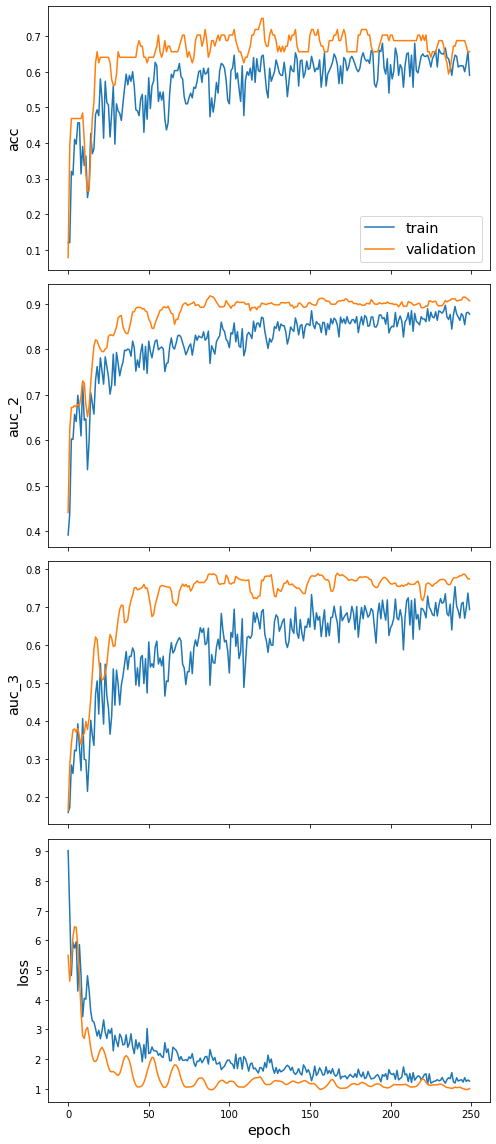

In [22]:
sg.utils.plot_history(history)

In [23]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 58ms/step - loss: 2.1061 - acc: 0.6462 - auc_2: 0.8459 - auc_3: 0.6246

Test Set Metrics:
	loss: 2.1061
	acc: 0.6462
	auc_2: 0.8459
	auc_3: 0.6246


In [24]:
all_nodes = series_classes.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [25]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": series_classes})

print(df['True'].value_counts(), "\n")
df['Predicted'].value_counts()

stage1     204
control     72
stage3      70
stage4      49
stage2      34
Name: True, dtype: int64 



stage1     289
control     74
stage4      46
stage3      20
Name: Predicted, dtype: int64

In [26]:
for component in G.connected_components():
    print(len(component))

401
7
3
3
3
2
2
2
2
2
2


In [27]:
G.node_degrees()

defaultdict(int,
            {'TCGA.CJ.5672.11': 70,
             'TCGA.CJ.5678.11': 55,
             'TCGA.B0.5712.11': 45,
             'TCGA.CZ.5458.11': 32,
             'TCGA.CW.5580.11': 70,
             'TCGA.CZ.5463.11': 70,
             'TCGA.CZ.5469.11': 30,
             'TCGA.CZ.4864.11': 49,
             'TCGA.B8.5549.11': 32,
             'TCGA.B0.5701.11': 69,
             'TCGA.CW.5581.11': 51,
             'TCGA.CZ.5455.11': 32,
             'TCGA.B0.5709.11': 54,
             'TCGA.CZ.5470.11': 38,
             'TCGA.CJ.5676.11': 53,
             'TCGA.CZ.5468.11': 39,
             'TCGA.CZ.5982.11': 50,
             'TCGA.CZ.5461.11': 68,
             'TCGA.CZ.5989.11': 35,
             'TCGA.CJ.6030.11': 53,
             'TCGA.CZ.5456.11': 29,
             'TCGA.CJ.5680.11': 52,
             'TCGA.B8.4622.11': 49,
             'TCGA.CW.6087.11': 65,
             'TCGA.B0.5694.11': 56,
             'TCGA.CZ.5466.11': 53,
             'TCGA.CJ.5679.11': 58,
           

## Correlation distribution among patients

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

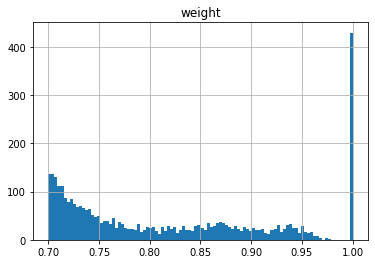

In [28]:
df_patients.hist(column='weight', bins=100)